In [1]:
import pandas as pd
import pymc_marketing as pmm
import matplotlib as mpl
import matplotlib.pyplot as plt
from cabm import post_processing as ppr

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Figure setup
# Set the font to Courier
mpl.rcParams['font.family'] = 'Courier'

# Set the line weight to thin
mpl.rcParams['lines.linewidth'] = 0.75

# Set the color scheme to black and white
mpl.rcParams['text.color'] = 'black'
mpl.rcParams['axes.labelcolor'] = 'black'
mpl.rcParams['xtick.color'] = 'black'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['axes.edgecolor'] = 'black'

In [12]:
agent_df = pd.read_pickle('agent_output_A_ADS_INCR.pkl')

In [13]:
agent_df = ppr.add_date_column(agent_df)

In [14]:
data_A = ppr.calculate_total_purchases(agent_df, ['price_A','tv_A','web_A', 'price_B', 'tv_B', 'web_B'])


In [15]:
data_A = ppr.add_total_sales_columns(data_A)

In [16]:
data_A = ppr.ensure_float_columns(data_A, exclude_columns=['Date','Step'])

In [17]:
data_a_mod = data_A[52:].reset_index(drop=True)

In [18]:
data_a_mod['Total_Sales_A'] = data_a_mod['Total_Sales_A'] * 1000
data_a_mod['Total_Sales_B'] = data_a_mod['Total_Sales_B'] * 1000

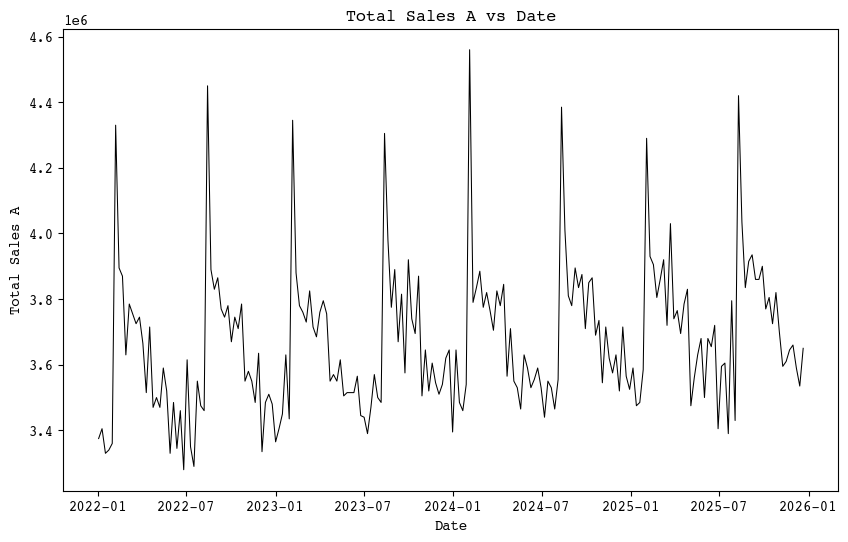

In [19]:
plt.figure(figsize=(10,6))
plt.plot(data_a_mod['Date'], data_a_mod['Total_Sales_A'],color='black')
plt.xlabel('Date')
plt.ylabel('Total Sales A')
plt.title('Total Sales A vs Date')
plt.show()


In [20]:
data_a_mod.to_csv("sim_data_trunc.csv", index=False)

In [21]:
# Define the columns
date_column = 'Date'
channel_columns = ['tv_A', 'web_A']
control_columns = ['Total_Sales_B']

my_sampler_config = {
    'tune': 1000,
    'draws': 1000,
    'chains': 4,
    #'target_accept': 0.9  # Increase this value to increase target_accept
}

# Instantiate the model
mmm = pmm.mmm.delayed_saturated_mmm.DelayedSaturatedMMM(
    sampler_config=my_sampler_config,
    date_column=date_column,
    channel_columns=channel_columns,
    control_columns=control_columns,
    adstock_max_lag=8,
)

In [31]:
# Split data into predictors (X) and target (y)
X = data_a_mod.drop('Total_Sales_A', axis=1)
y = data_a_mod['Total_Sales_A']

# Fit the model
mmm.fit(X, y)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_channel, alpha, lam, gamma_control, likelihood_sigma]


Output()

ValueError: Not enough samples to build a trace.

In [23]:
import arviz as az
import pymc as pm
import seaborn as sns

In [24]:
mmm.fit_result

<xarray.Dataset> Size: 54MB
Dimensions:                    (chain: 4, draw: 1000, channel: 2, date: 208,
                                control: 1)
Coordinates:
  * chain                      (chain) int64 32B 0 1 2 3
  * draw                       (draw) int64 8kB 0 1 2 3 4 ... 996 997 998 999
  * channel                    (channel) <U5 40B 'tv_A' 'web_A'
  * date                       (date) datetime64[ns] 2kB 2022-01-02 ... 2025-...
  * control                    (control) <U13 52B 'Total_Sales_B'
Data variables:
    alpha                      (chain, draw, channel) float64 64kB 0.104 ... ...
    beta_channel               (chain, draw, channel) float64 64kB 0.3119 ......
    channel_adstock            (chain, draw, date, channel) float64 13MB 0.0 ...
    channel_adstock_saturated  (chain, draw, date, channel) float64 13MB 0.0 ...
    channel_contributions      (chain, draw, date, channel) float64 13MB 0.0 ...
    control_contributions      (chain, draw, date, control) float64 7MB -0.27...
    gamma_control              (chain, draw, control) float64 32kB -2.662e-07...
    intercept                  (chain, draw) float64 32kB 1.034 1.026 ... 1.001
    lam                        (chain, draw, channel) float64 64kB 0.5081 ......
    likelihood_sigma           (chain, draw) float64 32kB 0.029 ... 0.03056
    mu                         (chain, draw, date) float64 7MB 0.7638 ... 0.7633
Attributes:
    created_at:                 2024-06-30T13:52:30.472191+00:00
    arviz_version:              0.18.0
    inference_library:          pymc
    inference_library_version:  5.15.1
    sampling_time:              163.22054886817932
    tuning_steps:               1000

In [25]:
az.summary(
    data=mmm.fit_result,
    var_names=[
        "intercept",
        "likelihood_sigma",
        "beta_channel",
        "alpha",
        "lam",
    ],
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,1.002,0.017,0.971,1.035,0.000,0.000,2521.0,2404.0,1.00
likelihood_sigma,0.030,0.001,0.027,0.033,0.000,0.000,3502.0,2479.0,1.00
beta_channel[tv_A],0.141,0.127,0.042,0.343,0.003,0.002,1553.0,1863.0,1.00
beta_channel[web_A],0.150,0.154,0.042,0.357,0.005,0.004,1265.0,1089.0,1.01
alpha[tv_A],0.226,0.123,0.001,0.425,0.003,0.002,1883.0,1042.0,1.00
alpha[web_A],0.363,0.122,0.129,0.585,0.003,0.002,2043.0,1402.0,1.00
lam[tv_A],1.890,1.299,0.140,4.219,0.028,0.020,1653.0,1863.0,1.00
lam[web_A],1.809,1.140,0.161,3.831,0.028,0.020,1249.0,1117.0,1.00


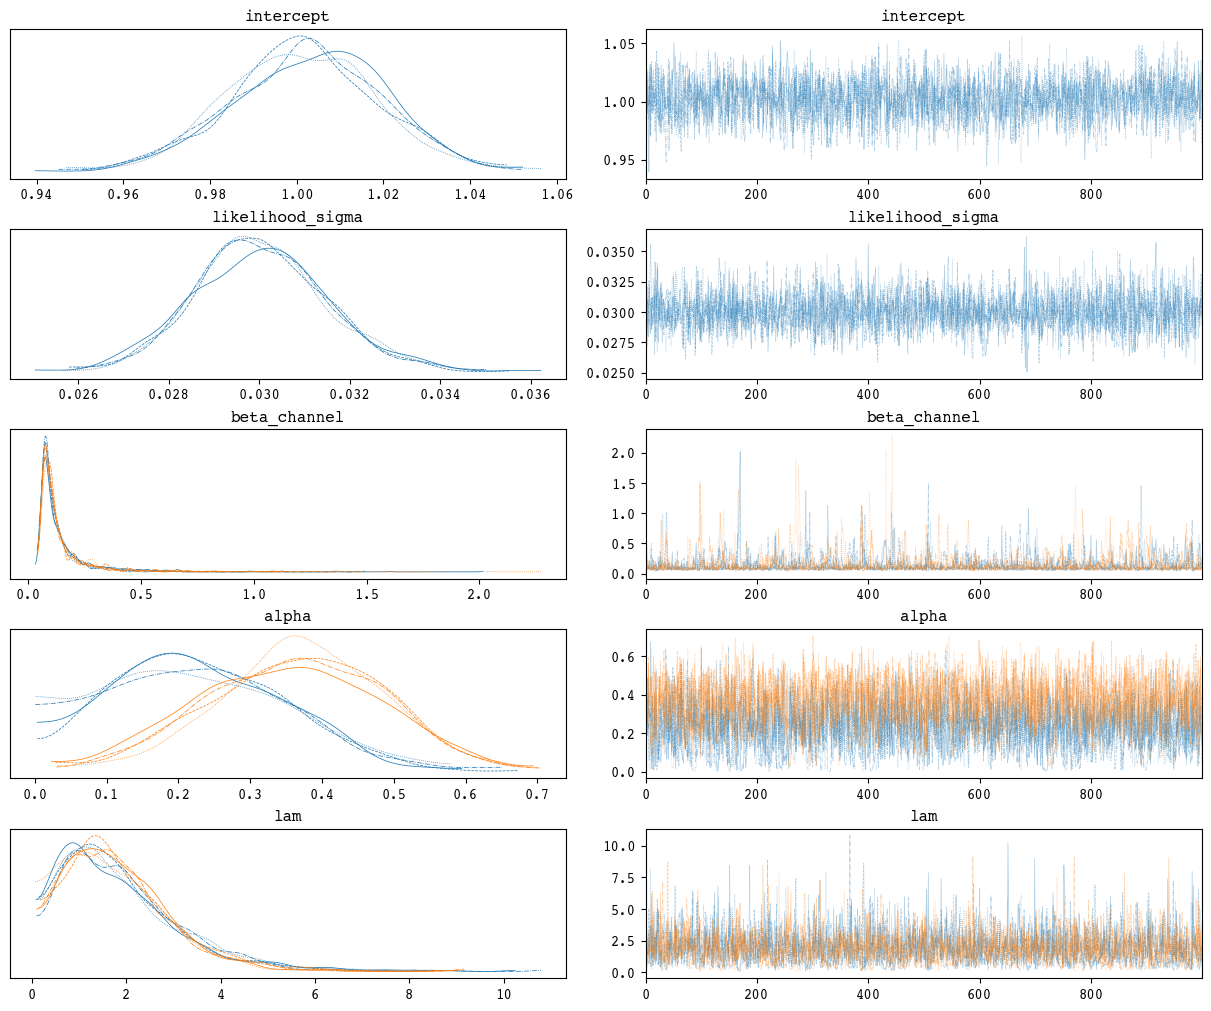

In [26]:
_ = az.plot_trace(
    data=mmm.fit_result,
    var_names=[
        "intercept",
        "likelihood_sigma",
        "beta_channel",
        "alpha",
        "lam",
    ],
    compact=True,
    backend_kwargs={"figsize": (12, 10), "layout": "constrained"},
)

In [27]:
mmm.sample_posterior_predictive(X, extend_idata=True, combined=True)

Sampling: [y]


Output()

<xarray.Dataset> Size: 7MB
Dimensions:  (date: 208, sample: 4000)
Coordinates:
  * date     (date) datetime64[ns] 2kB 2022-01-02 2022-01-09 ... 2025-12-21
  * sample   (sample) object 32kB MultiIndex
  * chain    (sample) int64 32kB 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 32kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    y        (date, sample) float64 7MB 3.415e+06 3.392e+06 ... 3.624e+06
Attributes:
    created_at:                 2024-06-30T13:52:45.289753+00:00
    arviz_version:              0.18.0
    inference_library:          pymc
    inference_library_version:  5.15.1

/Users/michael/.venvs/pymmm_0_6_0/lib/python3.12/site-packages/sklearn/utils/deprecation.py:129: FutureWarning: Xt was renamed X in version 1.5 and will be removed in 1.7.
  warnings.warn(
/Users/michael/.venvs/pymmm_0_6_0/lib/python3.12/site-packages/sklearn/utils/deprecation.py:129: FutureWarning: Xt was renamed X in version 1.5 and will be removed in 1.7.
  warnings.warn(


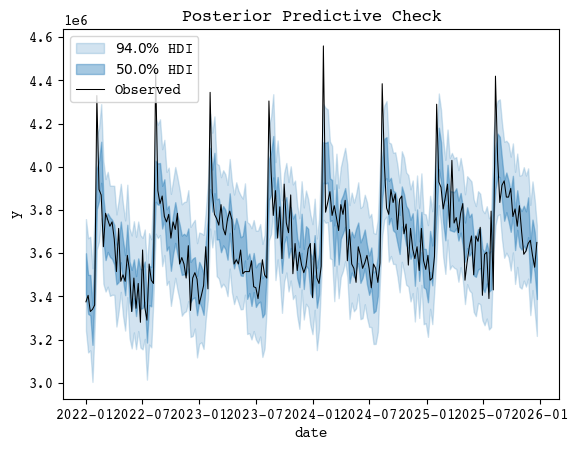

In [28]:
mmm.plot_posterior_predictive(original_scale=True);

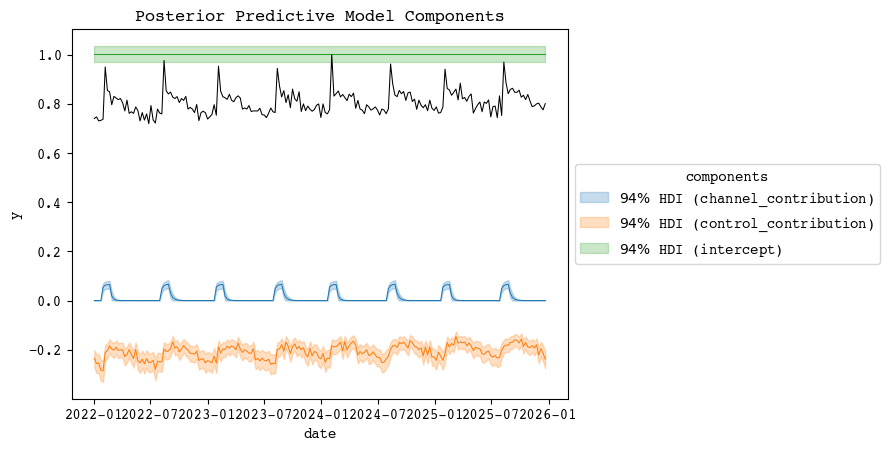

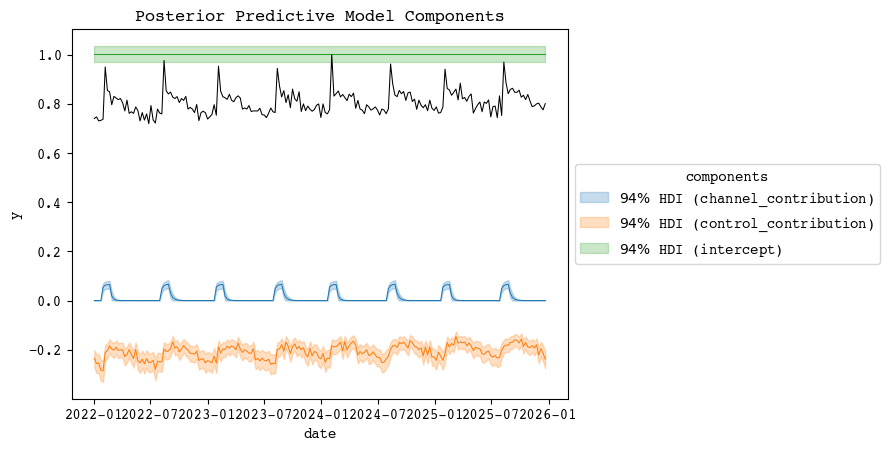

In [29]:
mmm.plot_components_contributions()

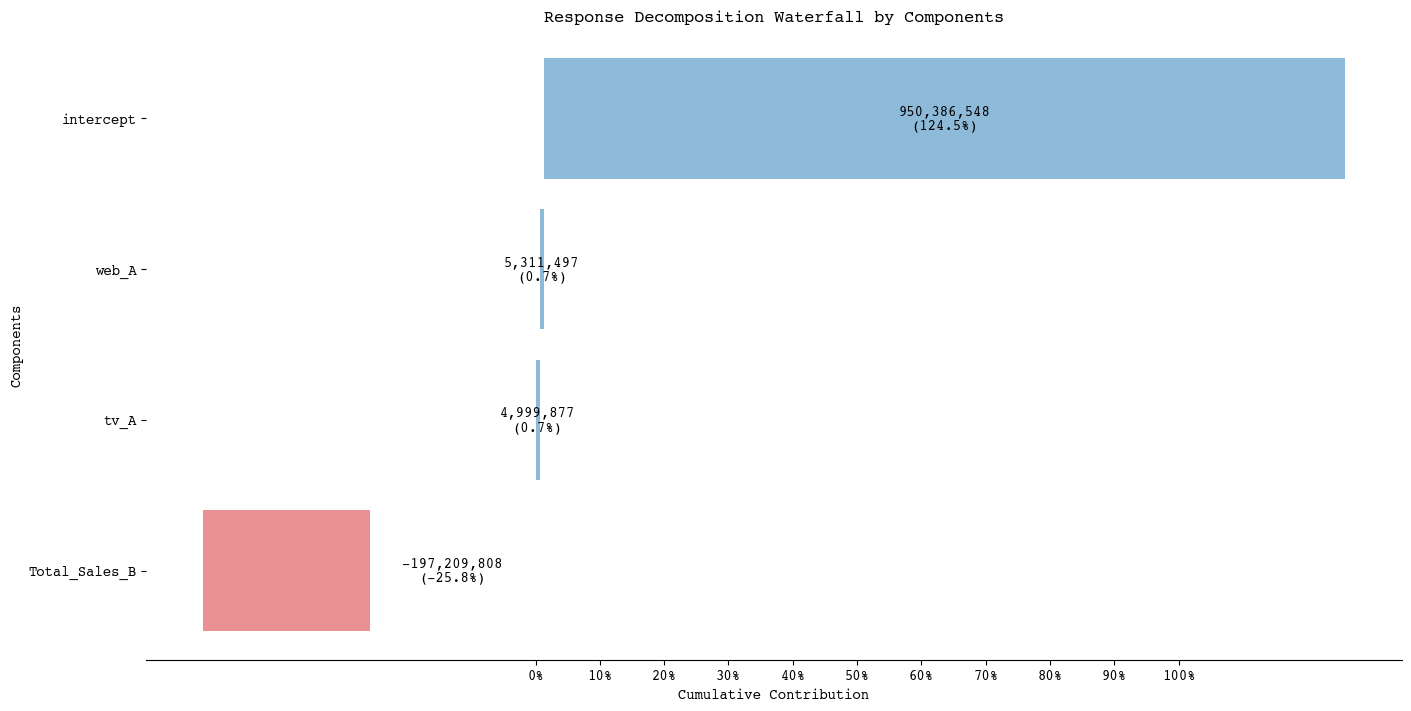

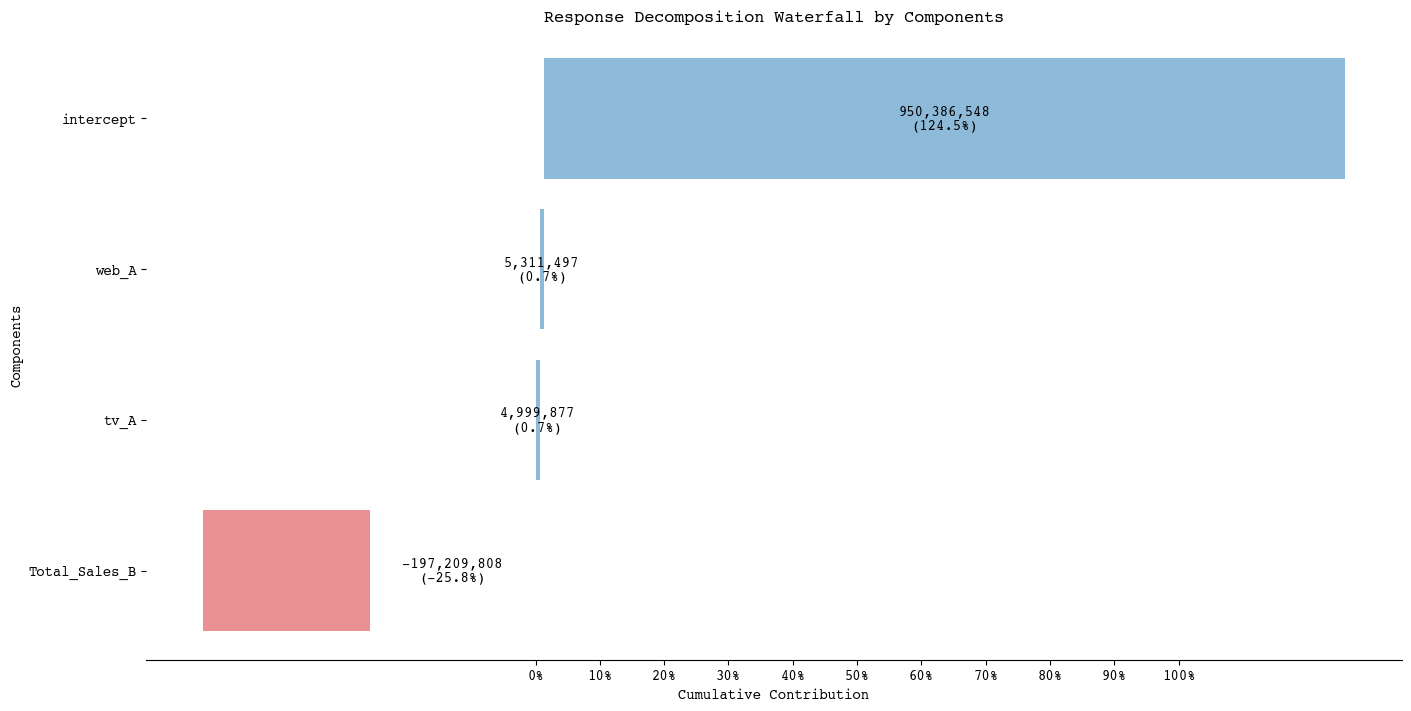

In [30]:
mmm.plot_waterfall_components_decomposition()

In [29]:
import pprint

In [30]:
dummy_model = DelayedSaturatedMMM(date_column="", channel_columns="", adstock_max_lag=4)
pprint.pprint(dummy_model.default_model_config)

{'alpha': {'dist': 'Beta', 'kwargs': {'alpha': 1, 'beta': 3}},
 'beta_channel': {'dist': 'HalfNormal', 'kwargs': {'sigma': 2}},
 'gamma_control': {'dist': 'Normal', 'kwargs': {'mu': 0, 'sigma': 2}},
 'gamma_fourier': {'dist': 'Laplace', 'kwargs': {'b': 1, 'mu': 0}},
 'intercept': {'dist': 'Normal', 'kwargs': {'mu': 0, 'sigma': 2}},
 'lam': {'dist': 'Gamma', 'kwargs': {'alpha': 3, 'beta': 1}},
 'likelihood': {'dist': 'Normal',
                'kwargs': {'sigma': {'dist': 'HalfNormal',
                                     'kwargs': {'sigma': 2}}}}}
